<a href="https://colab.research.google.com/github/TheFourStooges/TheFourStooges.github.io/blob/main/test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#garbage collector
import gc
gc.enable() #enabling collection


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
orders = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/orders.csv')
order_products_prior = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/order_products__prior.csv')
order_products_train = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/order_products__train.csv')
products = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/products.csv', usecols=['product_id', 'aisle_id', 'department_id'])
aisles = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/aisles.csv')
departments = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/departments.csv')
orders.eval_set = orders.eval_set.replace({'prior': 0, 'train': 1, 'test':2})
orders.days_since_prior_order = orders.days_since_prior_order.fillna(30)

In [5]:
#merging orders and prior datasets
prior_orders = pd.merge(orders, order_products_prior, on='order_id', how='inner')
prior_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,0,1,2,8,30.0,196,1,0
1,2539329,1,0,1,2,8,30.0,14084,2,0
2,2539329,1,0,1,2,8,30.0,12427,3,0
3,2539329,1,0,1,2,8,30.0,26088,4,0
4,2539329,1,0,1,2,8,30.0,26405,5,0


In [6]:
#deleting prior dataset
del order_products_prior
gc.collect()

0

In [7]:
#number of orders placed by each user.
users = prior_orders.groupby(by='user_id')['order_number'].aggregate('max').to_frame('u_num_of_orders').reset_index()
# #converting the datatype to int.
# users.u_num_of_orders = users.u_num_of_orders.astype(np.uint8)
users.head()

,user_id,u_num_of_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [8]:
#average products in orders placed by each users.

#1. First getting the total number of products in each order.
total_prd_per_order = prior_orders.groupby(by=['user_id', 'order_id'])['product_id'].aggregate('count').to_frame('total_products_per_order').reset_index()

#2. Getting the average products purchased by each user
avg_products = total_prd_per_order.groupby(by=['user_id'])['total_products_per_order'].mean().to_frame('u_avg_prd').reset_index()
avg_products.head()

#deleting the total_prd_per_order dataframe
del [total_prd_per_order]
gc.collect()

avg_products.head()

,user_id,u_avg_prd
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


In [9]:
#dow the user has ordered most.
#importing the scipy's stats model
# from scipy import stats


# #execution will take approx 45sec.
# dow = prior_orders.groupby(by=['user_id'])['order_dow'].aggregate(lambda x : stats.mode(x)[0]).to_frame('dow_u_most_orders')
# #resetting the index
# dow = dow.reset_index()
# dow.head()
# dow = prior_orders.groupby('user_id')['order_dow'].agg(pd.Series.mode).to_frame('dow_u_most_orders')
# dow = dow.reset_index()
# dow.head()

from scipy import stats

dow = prior_orders.groupby('user_id')['order_dow'].agg(lambda x: stats.mode(x)[0][0]).to_frame('dow_u_most_orders')
dow = dow.reset_index()
dow.head()




<ipython-input-9-72004fa1b827>:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  dow = prior_orders.groupby('user_id')['order_dow'].agg(lambda x: stats.mode(x)[0][0]).to_frame('dow_u_most_orders')


,user_id,dow_u_most_orders
0,1,4
1,2,2
2,3,0
3,4,4
4,5,3


In [10]:
#hour of day the user has ordered most.

#execution will take approx 45sec.
hod = prior_orders.groupby('user_id')['order_hour_of_day'].agg(lambda x: stats.mode(x)[0][0]).to_frame('hod_u_most_orders')
hod = hod.reset_index()
hod.head()

<ipython-input-10-c3da9d6d1b69>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  hod = prior_orders.groupby('user_id')['order_hour_of_day'].agg(lambda x: stats.mode(x)[0][0]).to_frame('hod_u_most_orders')


,user_id,hod_u_most_orders
0,1,7
1,2,9
2,3,16
3,4,15
4,5,18


In [11]:
#reorder ratio of user.
reorder_u = prior_orders.groupby('user_id')['reordered'].aggregate('mean').to_frame('u_reorder_ratio').reset_index()
#changing the dtype.
reorder_u['u_reorder_ratio'] = reorder_u['u_reorder_ratio'].astype(np.float16)
reorder_u.head()

,user_id,u_reorder_ratio
0,1,0.694824
1,2,0.476807
2,3,0.625000
3,4,0.055542
4,5,0.378418


In [12]:
#filling the NAN values with 0.
prior_orders.days_since_prior_order.fillna(0, inplace=True)


In [13]:
#average days between orders.
avg_days = prior_orders.groupby(by='user_id')['days_since_prior_order'].aggregate('mean').to_frame('average_days_between_orders')
#resetting index
avg_days = avg_days.reset_index()
avg_days.head()

,user_id,average_days_between_orders
0,1,21.084746
1,2,16.902564
2,3,13.590909
3,4,18.611111
4,5,19.108108


In [14]:
#total items bought.
total_item = prior_orders.groupby(by='user_id').size().to_frame('u_total_items_bought').astype(np.int16)
total_item.head()

,u_total_items_bought
user_id,
1,59
2,195
3,88
4,18
5,37


In [15]:
#merging users df and avg_prd
users = users.merge(avg_products, on='user_id', how='left')
#merging users df with dow
users = users.merge(dow, on='user_id', how='left')
#merging users df with hod
users = users.merge(hod, on='user_id', how='left')
#merging users df with reorder_u
users = users.merge(reorder_u, on='user_id', how='left')
#merging users df with avg_days
users = users.merge(avg_days, on='user_id', how='left')
#merging total_item df with reorder_u
users = users.merge(total_item, on='user_id', how='left')

users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought
0,1,10,5.900000,4,7,0.694824,21.084746,59
1,2,14,13.928571,2,9,0.476807,16.902564,195
2,3,12,7.333333,0,16,0.625000,13.590909,88
3,4,5,3.600000,4,15,0.055542,18.611111,18
4,5,4,9.250000,3,18,0.378418,19.108108,37


In [16]:
#deleting unwwanted df
del [reorder_u, dow, hod, avg_products, avg_days, total_item]
gc.collect()

0

In [17]:
#number of times purchased.
prd = prior_orders.groupby(by='product_id')['order_id'].aggregate('count').to_frame('p_num_of_times').reset_index()
# prd['p_num_of_times'] = prd['p_num_of_times'].astype(np.uint16)
prd.head()

,product_id,p_num_of_times
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [18]:
#reordered ratio for each product
reorder_p = prior_orders.groupby(by='product_id')['reordered'].aggregate('mean').to_frame('p_reorder_ratio').reset_index()
# #changing dtype
# reorder_p['p_reorder_ratio'] = reorder_p['p_reorder_ratio'].astype(np.float16)
reorder_p.head()

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000


In [19]:
#add to cart for each product.
add_to_cart = prior_orders.groupby(by='product_id')['add_to_cart_order'].aggregate('mean').to_frame('p_avg_cart_position').reset_index()
# #changing the dtype
# add_to_cart['p_avg_cart_position'] = add_to_cart['p_avg_cart_position'].astype(np.float16)
add_to_cart.head()

,product_id,p_avg_cart_position
0,1,5.801836
1,2,9.888889
2,3,6.415162
3,4,9.507599
4,5,6.466667


In [20]:
#merging reorder_p with prd.
prd = prd.merge(reorder_p, on='product_id', how='left')

#merging add_to_cart with prd.
prd = prd.merge(add_to_cart, on='product_id', how='left')

#deleting unwanted df.
del [reorder_p, add_to_cart]
gc.collect()

0

In [21]:
prd.head()

,product_id,p_num_of_times,p_reorder_ratio,p_avg_cart_position
0,1,1852,0.613391,5.801836
1,2,90,0.133333,9.888889
2,3,277,0.732852,6.415162
3,4,329,0.446809,9.507599
4,5,15,0.600000,6.466667


In [22]:
#times a user have bough a product.
uxp = prior_orders.groupby(by=['user_id', 'product_id'])['order_id'].aggregate('count').to_frame('uxp_times_bought')
#resetting index
uxp = uxp.reset_index()
# #changing the dtype.
# uxp['uxp_times_bought'] = uxp['uxp_times_bought'].astype(np.uint8)
uxp.head()

,user_id,product_id,uxp_times_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [23]:
#times a user have bough a product.
times = prior_orders.groupby(by=['user_id', 'product_id'])['order_id'].aggregate('count').to_frame('times_bought')
#resetting index
times = times.reset_index()
# #changing the dtype.
# times['times_bought'] = times['times_bought'].astype(np.uint8)
times.head()

,user_id,product_id,times_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [24]:
#Total orders
total_orders = prior_orders.groupby('user_id')['order_number'].max().to_frame('total_orders').reset_index()
total_orders.head()

,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [25]:
#Finding when the user has bought a product the first time.
first_order_num = prior_orders.groupby(by=['user_id', 'product_id'])['order_number'].aggregate('min').to_frame('first_order_num')
#resetting the index
first_order_num = first_order_num.reset_index()
first_order_num.head()

,user_id,product_id,first_order_num
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [26]:
#merging both the dataframes
span = pd.merge(total_orders, first_order_num, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_num
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


In [27]:
#Calculating the order range.
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.total_orders - span.first_order_num + 1
span.head()

,user_id,total_orders,product_id,first_order_num,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


In [28]:
#merging times df with the span
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,times_bought,total_orders,first_order_num,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


In [29]:
#calculating the ratio.
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.times_bought / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,times_bought,total_orders,first_order_num,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


In [30]:
#dropping all the unwanted columns.
uxp_ratio.drop(['times_bought', 'total_orders', 'first_order_num', 'Order_Range_D'], axis=1, inplace=True)
uxp_ratio.head()

,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [31]:
#deleting all the unwanted df.
del [times, span, first_order_num, total_orders]
gc.collect()

44

In [32]:
#merging uxp_ratio with uxp.
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')
#deleting uxp_ratio
del uxp_ratio
#calling garbage collector.
gc.collect()

0

In [33]:
uxp.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


In [34]:
#Reversing the order number for each product.
prior_orders['order_number_back'] = prior_orders.groupby(by=['user_id'])['order_number'].transform(max) - prior_orders.order_number + 1
prior_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2539329,1,0,1,2,8,30.0,196,1,0,10
1,2539329,1,0,1,2,8,30.0,14084,2,0,10
2,2539329,1,0,1,2,8,30.0,12427,3,0,10
3,2539329,1,0,1,2,8,30.0,26088,4,0,10
4,2539329,1,0,1,2,8,30.0,26405,5,0,10


In [35]:
#keeping only the first 5 orders from the order_number_back.
temp = prior_orders.loc[prior_orders.order_number_back <= 5]
temp.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
29,3367565,1,0,6,2,7,19.0,196,1,1,5
30,3367565,1,0,6,2,7,19.0,12427,2,1,5
31,3367565,1,0,6,2,7,19.0,10258,3,1,5
32,3367565,1,0,6,2,7,19.0,25133,4,1,5
33,550135,1,0,7,1,9,20.0,196,1,1,4


In [36]:
#product bought by users in the last_five orders.
last_five = temp.groupby(by=['user_id', 'product_id'])['order_id'].aggregate('count').to_frame('uxp_last_five').reset_index()
last_five.head()

,user_id,product_id,uxp_last_five
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5


In [37]:
#ratio of the products bought in the last_five orders.
last_five['uxp_ratio_last_five'] = last_five.uxp_last_five / 5.0
# #changing the dtype.
# last_five['uxp_ratio_last_five'] = last_five['uxp_ratio_last_five'].astype(np.float16)
last_five.head()

,user_id,product_id,uxp_last_five,uxp_ratio_last_five
0,1,196,5,1.0
1,1,10258,5,1.0
2,1,12427,5,1.0
3,1,13032,2,0.4
4,1,25133,5,1.0


In [38]:
#merging this feature with uxp df.
uxp = uxp.merge(last_five, on=['user_id', 'product_id'], how='left')

del [last_five, temp]
gc.collect()
uxp.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five
0,1,196,10,1.000000,5.0,1.0
1,1,10258,9,1.000000,5.0,1.0
2,1,10326,1,0.166667,NaN,NaN
3,1,12427,10,1.000000,5.0,1.0
4,1,13032,3,0.333333,2.0,0.4


In [39]:
#filling the NAN values with 0.
uxp.fillna(0, inplace=True)
uxp.head(10)

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five
0,1,196,10,1.000000,5.0,1.0
1,1,10258,9,1.000000,5.0,1.0
2,1,10326,1,0.166667,0.0,0.0
3,1,12427,10,1.000000,5.0,1.0
4,1,13032,3,0.333333,2.0,0.4
5,1,13176,2,0.222222,0.0,0.0
6,1,14084,1,0.100000,0.0,0.0
7,1,17122,1,0.166667,0.0,0.0
8,1,25133,8,1.000000,5.0,1.0
9,1,26088,2,0.200000,0.0,0.0


In [40]:
uxp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13307953 entries, 0 to 13307952
Data columns (total 6 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              int64  
 1   product_id           int64  
 2   uxp_times_bought     int64  
 3   uxp_reorder_ratio    float64
 4   uxp_last_five        float64
 5   uxp_ratio_last_five  float64
dtypes: float64(3), int64(3)
memory usage: 710.7 MB


In [41]:
# #Merge uxp features with the user features
# #Store the results on a new DataFrame
data = uxp.merge(users, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought
0,1,196,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59
1,1,10258,9,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59
2,1,10326,1,0.166667,0.0,0.0,10,5.9,4,7,0.694824,21.084746,59
3,1,12427,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59
4,1,13032,3,0.333333,2.0,0.4,10,5.9,4,7,0.694824,21.084746,59


In [42]:
#Merging prd features with data.
data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position
0,1,196,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,35791,0.776480,3.721774
1,1,10258,9,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,1946,0.713772,4.277492
2,1,10326,1,0.166667,0.0,0.0,10,5.9,4,7,0.694824,21.084746,59,5526,0.652009,4.191097
3,1,12427,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,6476,0.740735,4.760037
4,1,13032,3,0.333333,2.0,0.4,10,5.9,4,7,0.694824,21.084746,59,3751,0.657158,5.622767


In [43]:
#deleting unwanted df.
del [users, prd, uxp]
gc.collect()

0

In [44]:
#shape of the dataset.
data.shape

(13307953, 16)

In [45]:
#keeping only the train and test set from the orders df.
orders_future = orders.loc[((orders.eval_set == 1) | (orders.eval_set == 2)), ['user_id', 'eval_set', 'order_id']]
orders_future.head()

,user_id,eval_set,order_id
10,1,1,1187899
25,2,1,1492625
38,3,2,2774568
44,4,2,329954
49,5,1,2196797


In [46]:
#merging the orders_future with data.
data = data.merge(orders_future, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,eval_set,order_id
0,1,196,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,35791,0.776480,3.721774,1,1187899
1,1,10258,9,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,1946,0.713772,4.277492,1,1187899
2,1,10326,1,0.166667,0.0,0.0,10,5.9,4,7,0.694824,21.084746,59,5526,0.652009,4.191097,1,1187899
3,1,12427,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,6476,0.740735,4.760037,1,1187899
4,1,13032,3,0.333333,2.0,0.4,10,5.9,4,7,0.694824,21.084746,59,3751,0.657158,5.622767,1,1187899


In [47]:
#Preparing training data set.
data_train = data[data.eval_set == 1]
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,eval_set,order_id
0,1,196,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,35791,0.776480,3.721774,1,1187899
1,1,10258,9,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,1946,0.713772,4.277492,1,1187899
2,1,10326,1,0.166667,0.0,0.0,10,5.9,4,7,0.694824,21.084746,59,5526,0.652009,4.191097,1,1187899
3,1,12427,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,6476,0.740735,4.760037,1,1187899
4,1,13032,3,0.333333,2.0,0.4,10,5.9,4,7,0.694824,21.084746,59,3751,0.657158,5.622767,1,1187899


In [48]:
#merging the information contained in the order_products__train.csv into data_train.
data_train = data_train.merge(order_products_train[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,35791,0.776480,3.721774,1,1187899,1.0
1,1,10258,9,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,1946,0.713772,4.277492,1,1187899,1.0
2,1,10326,1,0.166667,0.0,0.0,10,5.9,4,7,0.694824,21.084746,59,5526,0.652009,4.191097,1,1187899,NaN
3,1,12427,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,6476,0.740735,4.760037,1,1187899,NaN
4,1,13032,3,0.333333,2.0,0.4,10,5.9,4,7,0.694824,21.084746,59,3751,0.657158,5.622767,1,1187899,1.0


In [49]:
#filling the NAN values in the reordered
data_train.reordered.fillna(0, inplace=True)

In [50]:
# #setting user_id and product_id as index.
# data_train = data_train.set_index(['user_id', 'product_id'])

#deleting eval_set, order_id as they are not needed for training.
data_train.drop(['eval_set', 'order_id'], axis=1, inplace=True)

In [51]:
#head()
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,reordered
0,1,196,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,35791,0.776480,3.721774,1.0
1,1,10258,9,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,1946,0.713772,4.277492,1.0
2,1,10326,1,0.166667,0.0,0.0,10,5.9,4,7,0.694824,21.084746,59,5526,0.652009,4.191097,0.0
3,1,12427,10,1.000000,5.0,1.0,10,5.9,4,7,0.694824,21.084746,59,6476,0.740735,4.760037,0.0
4,1,13032,3,0.333333,2.0,0.4,10,5.9,4,7,0.694824,21.084746,59,3751,0.657158,5.622767,1.0


In [52]:
#Preparing the test dataset.
data_test = data[data.eval_set == 2]
data_test.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,eval_set,order_id
120,3,248,1,0.090909,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,6371,0.400251,10.620782,2,2774568
121,3,1005,1,0.333333,1.0,0.2,12,7.333333,0,16,0.625,13.590909,88,463,0.440605,9.498920,2,2774568
122,3,1819,3,0.333333,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,2424,0.492162,9.287541,2,2774568
123,3,7503,1,0.100000,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,12474,0.553551,9.547379,2,2774568
124,3,8021,1,0.090909,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,27864,0.591157,8.822854,2,2774568


In [53]:
# #setting user_id and product_id as index.
# data_test = data_test.set_index(['user_id', 'product_id'])

#deleting eval_set, order_id as they are not needed for training.
data_test.drop(['eval_set', 'order_id'], axis=1, inplace=True)

<ipython-input-53-5a7ba06ae702>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.drop(['eval_set', 'order_id'], axis=1, inplace=True)


In [54]:
#shape of train and test.
data_train.shape, data_test.shape

((8474661, 17), (4833292, 16))

In [55]:
# #resetting index
# data_train.reset_index()
# data_test.reset_index()

#adding aisle and department data
products = pd.read_csv('../content/drive/MyDrive/Colab Notebooks/' + 'products.csv', usecols=['product_id', 'aisle_id', 'department_id'])

#merging product data into data_train and data_test.
data_train = data_train.merge(products, on='product_id', how='left')
data_test = data_test.merge(products, on='product_id', how='left')

#setting the index again
data_train = data_train.set_index(['user_id', 'product_id'])
data_test = data_test.set_index(['user_id', 'product_id'])

In [56]:
#mean encoding categorical variables.
columns_mean = ['aisle_id', 'department_id']
for col in columns_mean:
        mean = data_train.groupby(col).reordered.mean()
        data_train[col] = data_train[col].map(mean)
        data_test[col] = data_test[col].map(mean)

In [57]:
#deleting unwanted df and collecting garbage
del [data, orders_future, products, order_products_train]
gc.collect()

0

In [58]:
#importing the necessary packages.
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.classifiers import plot_feature_importances

#importing model packages.
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb_lib

from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt



In [59]:
#Creating X and y variables.
X = data_train.drop(['reordered', 'uxp_ratio_last_five'], axis=1)
y = data_train.reordered

#splitting dataset into train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [60]:
#deleting X, y
del [data_train]
gc.collect()

26

In [61]:
#setting boosters parameters
parameters = {
    'eavl_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}

[15:27:58] WARNING: ../src/learner.cc:767: 
Parameters: { "num_boost_round", "parameters" } are not used.

F1 Score: 0.43381598312696074
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2206913
           1       0.51      0.38      0.43    335486

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87      0.86   2542399



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

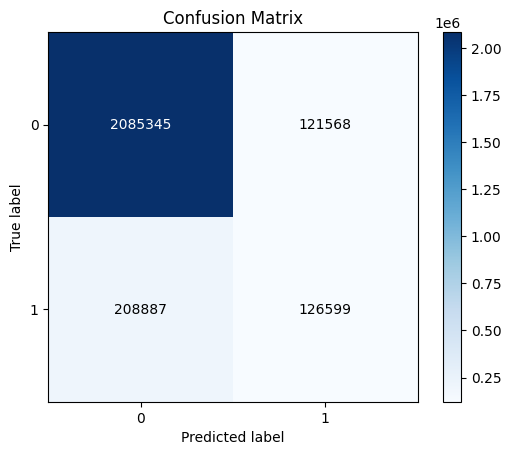

In [62]:
#Creating a XGBoost model.
# #Initializing the model
xgb = xgb_lib.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

# X_train['dow_u_most_orders'] = X_train['dow_u_most_orders'].apply(lambda x: int(x[0]) if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 1 else x)
# X_test['dow_u_most_orders'] = X_test['dow_u_most_orders'].apply(lambda x: int(x[0]) if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 1 else x)

# X_train['hod_u_most_orders'] = X_train['hod_u_most_orders'].apply(lambda x: int(x[0]) if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 1 else x)
# X_test['hod_u_most_orders'] = X_test['hod_u_most_orders'].apply(lambda x: int(x[0]) if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 1 else x)


#fitting the model.
xgb.fit(X_train, y_train)

#prediction
y_pred = (xgb.predict_proba(X_test)[:, 1] >= 0.21).astype('int') #setting a threshold.

#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))
plot_confusion_matrix(y_pred, y_test)



/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_feature_importances is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_feature_importances instead.
  warnings.warn(msg, category=FutureWarning)


<Axes: title={'center': 'Feature Importance'}>

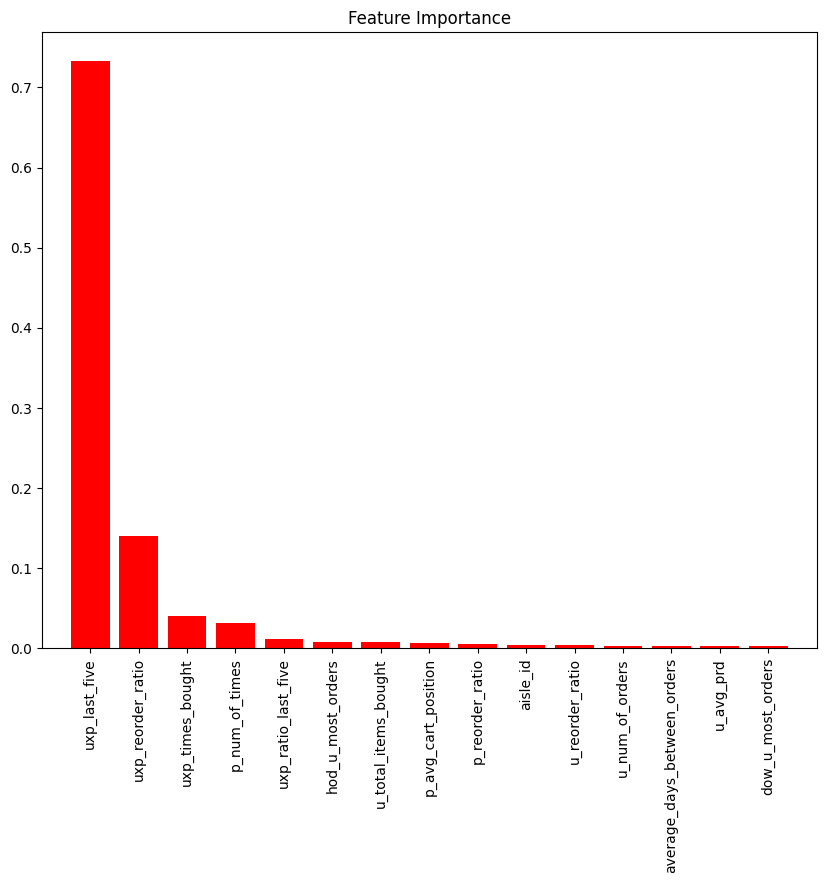

In [63]:
#plotting feature importance.
plot_feature_importances(xgb, feature_names=data_test.columns, x_tick_rotation=90, max_num_features=20, figsize=(10,8))


In [64]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
class DeepModelWrapper:
    def __init__(self, deep_model):
        self.model = deep_model
    
    def predict_proba(self, test_x):
        pred = self.model.predict(
            test_x,
            batch_size=256,
        )
        
        return pred

In [66]:
def evaluate(model, test_x, test_y):
    pred_proba = model.predict_proba(test_x)[:, 1]
    pred_class = (pred_proba >= 0.5).astype(int)
    
    acc = accuracy_score(test_y, pred_class)
    p, r, f1, _ = precision_recall_fscore_support(test_y, pred_class, average='binary')
    roc = roc_auc_score(test_y, pred_proba)
    
    result = {
        'accuracy': acc,
        'precision': p,
        'recall': r,
        'f1': f1,
        'roc': roc,
    }
    
    return pd.DataFrame.from_dict([result])

In [67]:


class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs


In [68]:
class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs

In [69]:
num_trees = 10
depth = 5
num_features = X_train.shape[1]
used_features_rate = 0.5
num_classes = 2

model = NeuralDecisionForest(num_trees, depth, num_features, used_features_rate, num_classes)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))


Epoch 1/10
23173/23173 [==============================] - 390s 16ms/step - loss: 0.6933 - binary_accuracy: 0.5007 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 2/10
23173/23173 [==============================] - 372s 16ms/step - loss: 0.6933 - binary_accuracy: 0.5019 - val_loss: 0.6932 - val_binary_accuracy: 0.4999
Epoch 3/10
23173/23173 [==============================] - 370s 16ms/step - loss: 0.6933 - binary_accuracy: 0.5034 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 4/10
23173/23173 [==============================] - 371s 16ms/step - loss: 0.6933 - binary_accuracy: 0.5048 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 5/10
23173/23173 [==============================] - 371s 16ms/step - loss: 0.6933 - binary_accuracy: 0.5019 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 6/10
23173/23173 [==============================] - 372s 16ms/step - loss: 0.6933 - binary_accuracy: 0.5056 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 7/10
23173/23173

In [70]:
wrapped_model = DeepModelWrapper(model)
evaluation_results = evaluate(wrapped_model, X_test, y_test)
print(evaluation_results)



9932/9932 [==============================] - 48s 5ms/step
   accuracy  precision  recall        f1       roc
0  0.097611   0.097611     1.0  0.177861  0.582261
